#### The opinion of agent $P_i$ on another agent $P_j$ is the reputation $s_{ij}$ of $P_j$ local to $P_i$.

$$s_{ij} = \sum_{y_{ij}\in Y_{ij}} rating_i(y_{ij})$$

$$c_{ij} = \frac{max(s_{ij},0)}{\sum_j max(s_{ij},0)}$$

In [7]:
### PEER DEFINITION ###

class P:
    # w_prob is the probability of computing tasks wrong
    def __init__(self, uid, w_prob):
        self.uid = uid
        self.w_prob = w_prob
        self.managed = None
        
        self.occupied = 0
        self.times_occupied = 0
        self.local_scores = dict()
        self.global_scores = None
        
    def assign_managers(self, uids):
        self.managers = uids
        
    def assign_managed(self, uid):
        if self.managed == None:
            self.managed = [uid]
        else:
            self.managed.append(uid)
            
        if self.global_scores == None:
            self.global_scores = dict()
        
        # bootstrap reputation of unknown peer
        self.global_scores[uid] = 0.5
        
    def pass_round(self):
        self.occupied -= 1
        self.occupied = max(self.occupied, 0)


In [8]:
### SETTING UP THE NETWORK ###
import random

'''
Initialize a network with n peers, where each peer
has n_SM score managers.

m_ration indicates the percentage of peers that are
malitious, and that will return wrong results with
probability m_prob. The rest of peers are considered
honest, and will return a wrong result with g_prob.

We assume that even honest peers might make mistakes
with a small probability.
'''
def init_network(n, n_SM, g_prob, m_prob, m_ratio):
    # Initialize peers
    NETWORK = {}
    malicious_peers = int(n * m_ratio)
    for i in range(n):
        if i < malicious_peers:
            NETWORK[i] = P(i, m_prob)
        else:
            NETWORK[i] = P(i, g_prob)

    # Assign managers
    peer_list = list(NETWORK.keys())
    for i in range(n):
        man = random.sample(peer_list, k=n_SM)
        # A peer cannot be its own manager
        while i in man:
            man = random.sample(peer_list, k=n_SM)
        NETWORK[i].assign_managers(man)
        for m in man:
            NETWORK[m].assign_managed(i)
    
    return NETWORK


### Protocol 1 Reputation-based co-utile P2P computing
Input: $m$ and $g > 1$
1. $R$ splits the computation $C$ into a number of tasks $C_1, C_2, \dots , C_m$, each including code and data;
2. Let $m_0 = m \times g$;
3. **if** global peer reputations are available **then**
4.  &nbsp; &nbsp; $R$ selects the $m_0$ peers with the highest global reputation among the total $n$ peers;
5. **else**
6. &nbsp; &nbsp; $R$ selects a random subset of $m_0$ peers among the total $n$ peers;
7. **end if**
8. $R$ computes and publishes a random permutation $\pi(L)$ of the $m_0$ selected peer pseudonyms;
9. $R$ sends task $C_1$ to the first $g$ peers in $\pi(L)$, task $C_2$ to the next $g$ peers in $\pi(L)$, and in general $C_i$ to the $i$-th group of $g$ peers in $\pi(L)$;
10. **for all** selected peers **do**
11. &nbsp; &nbsp; Complete the assigned task;
12. **end for**
13. **for all** score managers $SM$ **do**
14. &nbsp; &nbsp; **for all** daughter $P_i \in \pi(L)$ **do**
15. &nbsp; &nbsp; &nbsp; &nbsp; $SM$ looks for the $g − 1$ peers $P_j \in \pi(L)$ that had the same task as $P_i$;
16. &nbsp; &nbsp; &nbsp; &nbsp; **if** $P_i$ and $P_j$ have obtained the same result **then**
17. &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; $SM$ assigns local reputation $c_{ji} = 1/(g − 1)$ to $P_i$;
18. &nbsp; &nbsp; &nbsp; &nbsp; **else**
19. &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; $SM$ assigns $c_{ji} = 0$ to $P_i$;
20. &nbsp; &nbsp; &nbsp; &nbsp; **end if**
21. &nbsp; &nbsp; **end for**
22. **end for**
23. Call Protocol 2 to obtain the global reputation $t_i$ of each peer $P_i$.

### Protocol 2 Co-utile P2P global reputation computation
1. **for all** $P_i$ **do**
2. &nbsp; &nbsp; **for all** daughters $P_d$ of $P_i$ **do**
3. &nbsp; &nbsp; &nbsp; &nbsp; **for all** $g − 1$ peers $P_j$ that had the same task as $P_d$ **do**
4. &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Query all the score managers of $P_j$ for $c_{jd}t^{(0)}_j$;
5. &nbsp; &nbsp; &nbsp; &nbsp; **end for**
6. &nbsp; &nbsp; &nbsp; &nbsp; k := −1;
7. &nbsp; &nbsp; &nbsp; &nbsp; **repeat**
8. &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; k := k + 1;
9. &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Compute $t^{(k+1)}_d = c_{1d}t^{(k)}_1 + c_{2d}t^{(k)}_2 + \dots + c_{nd}t^{(k)}_n$;
10. &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; **for all** $g − 1$ peers $P_j$ that had the same task as $P_d$ **do**
11. &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Send $c_{dj}t^{(k+1)}_d$ to all the score managers of $P_j$;
12. &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Wait for all score managers of $P_j$ to return $c_{jd}t^{(k+1)}_j$;
13. &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; **end for**
14. &nbsp; &nbsp; &nbsp; &nbsp; **until** $|t^{(k+1)}_d − t^{(k)}_d| < \epsilon$;
15. &nbsp; &nbsp; **end for**
16. **end for**

In [12]:
from statistics import mean
from collections import Counter

def most_common(lst):
    data = Counter(lst)
    return max(lst, key=data.get)

def co_utile_computation(NETWORK, SM, m, subtasks, g, random_workers, task_duration):
    
    ### PROTOCOL 1 ###

    # Needed workers pi(L)
    m_0 = m * g
    assert(m_0 <= len(NETWORK))
    
    for pi in NETWORK.keys():
        NETWORK[pi].pass_round()
    
    available_workers = [p for p in NETWORK.keys() if NETWORK[p].occupied == 0]
    
    # Choose workers
    if random_workers:
        # Choose random workers
        workers = random.sample(available_workers, k=m_0)
    else:
        # Choose by score
        list_scores = [(pi, mean([NETWORK[p].global_scores[pi] for p in NETWORK[pi].managers])) for pi in available_workers]
        workers = sorted(list_scores, key=lambda x: x[1], reverse=True)[:m_0]
        workers = list([w[0] for w in workers]) 
        
    for pi in workers:
        NETWORK[pi].occupied = task_duration
        NETWORK[pi].times_occupied += 1

    # Assign tasks to workers
    TASK_ASSIGNMENT = dict()
    for tn in range(m):
        TASK_ASSIGNMENT[tn] = []
        for pn in range(g):
            TASK_ASSIGNMENT[tn].append(workers[tn*g+pn])
    
    # Complete tasks
    TASK_RESULTS = dict()
    TASK_RESULTS_MAJORITY = dict()
    for tn in range(m):
        TASK_RESULTS[tn] = []
        for pn in range(g):
            TASK_RESULTS[tn].append(subtasks[tn](NETWORK[TASK_ASSIGNMENT[tn][pn]].w_prob))
        TASK_RESULTS_MAJORITY[tn] = most_common(TASK_RESULTS[tn])

    # Reputation assignments
    for sm in SM:
        # Which peers managed by *sm* have participated in any of the tasks?
        daughters = [p for p in NETWORK[sm].managed if p in workers]
        for daughter in daughters:
            # What task was this peer assigned to?
            assigned_task = workers.index(daughter) // g
            # What other peers have the same task?
            peers_in_task = TASK_ASSIGNMENT[assigned_task]
            # What is the majority result
            majority = most_common(TASK_RESULTS[assigned_task])
            # Assign scores to the other peers participating in the same task.
            i = peers_in_task.index(daughter) 
            for j in range(g):
                if j != i:
                    other_uid = TASK_ASSIGNMENT[assigned_task][j]
                    other_result = TASK_RESULTS[assigned_task][j]
                    # Assign reputation
                    if majority == other_result:
                        NETWORK[daughter].local_scores[other_uid] = 1
                    else:
                        NETWORK[daughter].local_scores[other_uid] = 0

                    #NETWORK[daughter].local_scores[other_uid] = min(1.0, NETWORK[daughter].local_scores[other_uid])
                    #NETWORK[daughter].local_scores[other_uid] = max(0.0, NETWORK[daughter].local_scores[other_uid])
    
    ### PROTOCOL 2 ###
    
    # Score managers agree on current global reputations
    for pi in NETWORK.keys():
        ti = mean([NETWORK[man].global_scores[pi] for man in NETWORK[pi].managers])
        for man in NETWORK[pi].managers:
            NETWORK[man].global_scores[pi] = ti
    
    
    epsilon = 0.0001
    # for all Pi do
    for pi in SM:
        # for all daughters Pd of Pi (that participated in any task) do
        for pd in [p for p in NETWORK[pi].managed if p in workers]:
            # What other peers have the same task?
            peers_in_task = list(TASK_ASSIGNMENT[workers.index(pd) // g])
            peers_in_task.remove(pd)

            cjdtj = []
            for pj in peers_in_task:
                cjd = NETWORK[pj].local_scores[pd]
                tj = mean([NETWORK[man].global_scores[pj] for man in NETWORK[pj].managers])
                cjdtj.append(cjd*tj)
            td = sum(cjdtj)

            NETWORK[pi].global_scores[pd] = min(1, td) 
            #NETWORK[pi].global_scores[pd] = td
            
    # Score managers agree on current global reputations
    for pi in NETWORK.keys():
        ti = mean([NETWORK[man].global_scores[pi] for man in NETWORK[pi].managers])
        for man in NETWORK[pi].managers:
            NETWORK[man].global_scores[pi] = ti
            
    return TASK_RESULTS_MAJORITY

In [15]:
### TEST OF PROTOCOL ###

import random

def run_experiment(n, n_SM, m_ratio, g_prob, m_prob, m, g, rounds, random_workers, binary_task, task_duration):
    NETWORK = init_network(n, n_SM, g_prob, m_prob, m_ratio)
    peer_list = list(NETWORK.keys())

    # List of Score managers
    SM = [p for p in peer_list if NETWORK[p].managed is not None]
   
    if binary_task:
        # Dummy code for a trivial task with probability p of returning the wrong result: True is a correct result
        task = lambda p: random.random() >= p
    else:
        # Non binary task
        task = lambda p: 0 if random.random() >= p else random.random()

    TASKS = [task]*m

    quality = []
    for _ in range(rounds):
        maj = co_utile_computation(NETWORK, SM, m, TASKS, g, random_workers, task_duration)
        if binary_task:
            q = sum([1.0 for task_result_majority in maj.values() if task_result_majority == True]) / m
        else:
            q = sum([1.0 for task_result_majority in maj.values() if task_result_majority == 0]) / m
        quality.append(q)
        
    list_scores = [mean([NETWORK[p].global_scores[pi] for p in NETWORK[pi].managers]) for pi in peer_list]
    
    return NETWORK, list_scores, mean(list_scores), mean(quality)

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [17:20<00:00,  8.44s/it]


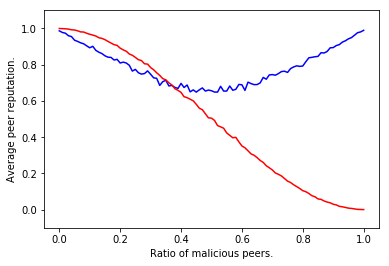

In [16]:
import numpy as np
from tqdm import tqdm
%matplotlib inline

# Probability of wrong result by honest peers
g_prob = 0.0
# Probability of wrong result by malicious peers
m_prob = 1.0

# Number of peers    
n = 100

# Number of score managers
n_SM = 3
assert(n_SM <= n)

# Number of subtasks
m = 10

# Number of peers per task
g = 3

# Number of rounds
rounds = 100

# Random workers?
random_workers = True

# Binary task?
binary_task = True

# Task duration
task_duration = 1
assert(n / (m * g) >= task_duration > 0)

res = []
quality = []
for p in tqdm(np.arange(0.0, 1.01, 0.01), leave=True, position=0):
    sc = []
    qual = []
    for _ in range(10):
        _, _, mean_scores, q = run_experiment(n, n_SM, p, g_prob, m_prob, m, g, rounds, random_workers, binary_task, task_duration)
        sc.append(mean_scores)
        qual.append(q)
    res.append(mean(sc))
    quality.append(mean(qual))

import matplotlib.pyplot as plt
plt.plot(np.arange(0.0, 1.01, 0.01), res, c='b')
plt.plot(np.arange(0.0, 1.01, 0.01), quality, c='r')
plt.ylim((-0.1, 1.1))   # set the ylim to bottom, top
plt.xlabel('Ratio of malicious peers.')
plt.ylabel('Average peer reputation.')
plt.show()
plt.close()